In [ ]:
#pip install num2words

In [ ]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
#from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from string import punctuation
from lxml import etree
from collections import defaultdict, Counter
#from num2words import num2words
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
import timeit

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Mounted at /content/drive


# Chargement

In [ ]:
N = 0
err = 0 
dict_stack = defaultdict(list)
freq = defaultdict(list)
questions = []
bodies = []
tags = []
len_q = 0
len_b = 0
len_t = 0

tokenizer = nltk.RegexpTokenizer(r'\w+')

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding='utf-8',\
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)

with open("db_StackOverflow.csv", 'r', encoding="utf-8", ) as file:
#with open("test.txt", 'r', encoding="ascii", ) as file:

    reader = csv.reader(file, delimiter = ',', quotechar = '"', skipinitialspace=True)
    for line in reader:
        question = []
        body = []
        tag = [abs]
        if line[0].isdigit():
            # tokennisation des titres et minuscules
            question = tokenizer.tokenize(line[1].lower()) 
            len_q += len(question)
            questions.extend(question)

            body = BeautifulSoup(line[2], 'html.parser')
            # Delete url strings
            for t in body.find_all('a'):
                t.replaceWith('')
            # Delete code blocks
            for t in body.find_all('pre'):
                t.replaceWith('')
            # tokennisation des détails et minuscules
            body = tokenizer.tokenize(body.get_text(" ", strip=True).lower())
            len_b += len(body)
            bodies.extend(body)
            
            # tokennisation des tags et minuscules
            tag = line[3].lower().split('><')
            tag[0] = tag[0].replace('<', '')
            tag[-1] = tag[-1].replace('>', '')
            len_t += len(tag)
            tags.extend(tag)

            dict_stack[int(line[0])] = [question, body, tag]
            
            N += 1 
            #if N == 1000:
                #break 

print('{} questions importées, {} ano(s)'.format(N, err))

50000 questions importées, 0 ano(s)


# Nettoyage du dataframe

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 169828 to 1669645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


## Traitement du html dans les bodies

In [ ]:
for i in range(train.shape[0]):
    temp = BeautifulSoup(train.iloc[i, 1], 'html.parser')
    # Delete url strings
    for t in temp.find_all('a'):
        t.replaceWith('')
    # Delete code blocks
    for t in temp.find_all('pre'):
        t.replaceWith('')
    train.iloc[i, 1] = temp.get_text(" ", strip=True)

## Passage en minuscules

In [ ]:
for col in train.columns:
    train[col] = train[col].str.lower()

## Suppression des stopwords standards

In [ ]:
# Stopwords nltk 
sw = set(nltk.corpus.stopwords.words('english')) 

for col in ['Title', 'Body']:
    for i in range(len(train)):
        idx = train.index[i]
        train.loc[idx, col] = [w for w in train.loc[idx, col].split() \
                               if not w in sw]

In [ ]:
train

,Title,Body,Tags
169828,"[real, benefits, visual, studio, team, system,...","[interested, anyone, used, vsts, database, edi...",<sql-server><database-tools>
431644,"[hook, current, formsauthenticationmodule, med...","[i've, got, httpmodule, application, hooks, fo...",<asp.net><events><forms-authentication><httpmo...
1450121,"[sync, algorithm/reference, available, syncing...","[i'm, planning, write, program, sync, folder, ...",<algorithm><synchronization>
426609,"[assign, profile, values?]","[know, missing,, added, profile, properties, w...",<asp.net><asp.net-mvc><asp.net-membership><pro...
14646,"[add, ""project, description"", fogbugz?]","[create, new, project, (or, even, edit, sample...",<fogbugz>
...,...,...,...
9876754,"[data(timestamp).tolocalestring, always, retur...","[code, date, always, current, date., mistake?,...",<java><android>
3820367,"[read, files, spaces, special, characters, name?]","[lots, videos, server, use, following, code, g...",<php><linux><file>
533465,"[encode, special, character, sitemaps?]","[url, contains, special, characters., example:...",<sitemap>
3712275,"[lazy, loading, objective-c, -, call, setter, ...","[small, detail, everytime, lazy, load, somethi...",<objective-c><memory-management><lazy-loading>...


# Dénombrements bruts

In [ ]:
freq['questions'] = Counter(questions).most_common()
freq['bodies'] = Counter(bodies).most_common()
freq['tags'] = Counter(tags).most_common()

print('{} mots dans les titres dont {} distincts, \n\
{}/{} dans les détails, \n{}/{} dans les tags'.\
      format(len_q, len(freq['questions']), \
             len_b, len(freq['bodies']), \
             len_t, len(freq['tags'])))

440777 mots dans les titres dont 18925 distincts, 
4809608/68240 dans les détails, 
145824/10494 dans les tags


## Explorations des tags

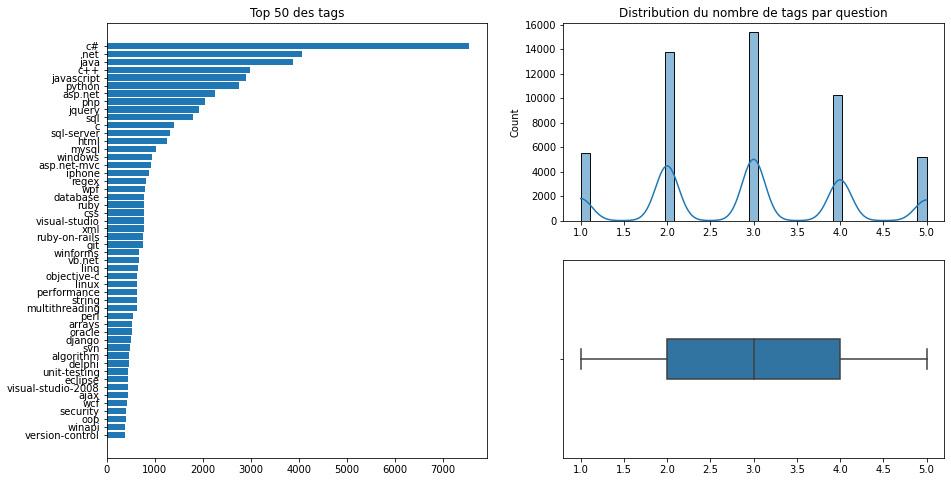

In [ ]:
top = 50
tags_top = freq['tags'][:top]

fig = plt.figure(1, figsize=(15, 8))
plt.subplot(121)
plt.barh([k for k, v in sorted(tags_top, key=lambda x: x[1])], 
         [v for k, v in sorted(tags_top, key=lambda x: x[1])])
plt.title('Top {} des tags'.format(top))
plt.subplot(222)
plt.title('Distribution du nombre de tags par question')
sns.histplot([len(v[2]) for k, v in dict_stack.items()], kde=True)
plt.subplot(224)
sns.boxplot(x=[len(v[2]) for k, v in dict_stack.items()], width=0.2)

Text(0.5, 1.0, 'Top 30 des mots significatifs (>4 car.) dans les détails')

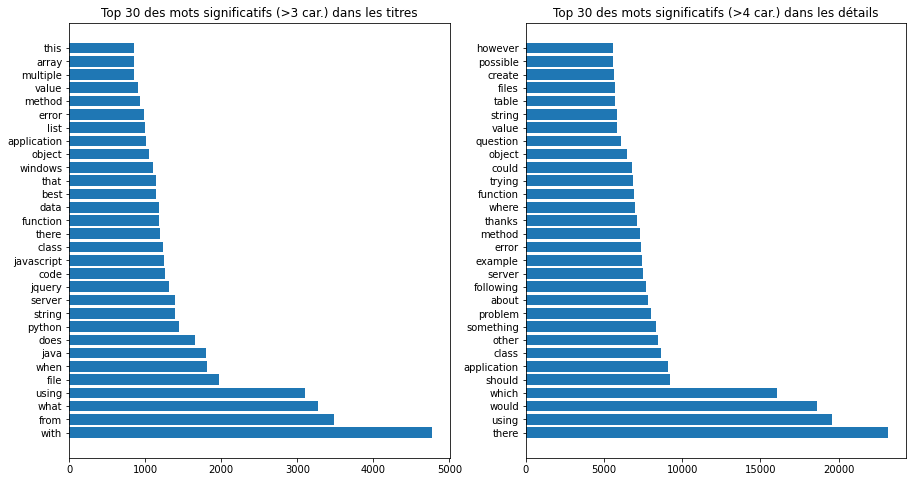

In [ ]:
top2 = 30

fig = plt.figure(1, figsize=(15, 8))
plt.subplot(121)
temp = {k: n for k, n in freq['questions'] if len(k)>3}
temp = sorted(temp.items(), key=lambda t: t[1], reverse=True)[:top2]
plt.barh([k for k, v in temp], 
         [v for k, v in temp])
plt.title('Top {} des mots significatifs (>3 car.) dans les titres'.format(top2))

plt.subplot(122)
temp = {k: n for k, n in freq['bodies'] if len(k)>4}
temp = sorted(temp.items(), key=lambda t: t[1], reverse=True)[:top2]
plt.barh([k for k, v in temp], 
         [v for k, v in temp])
plt.title('Top {} des mots significatifs (>4 car.) dans les détails'.format(top2))

# Réduction du scope
Pour commencer, je considère les questions avec 1 seul tag 

In [ ]:
nbtags = [1]
source = defaultdict(list)
questions = []
bodies = []
tags = []
cpt = 0

for i, j in dict_stack.items():
    if len(j[2]) in nbtags:
        source[i] = j
        questions.extend(j[0])
        bodies.extend(j[1])
        tags.extend(j[2])
        cpt += 1 

freq['questions'] = Counter(questions).most_common() 
freq['bodies'] = Counter(bodies).most_common()
freq['tags'] = Counter(tags).most_common()
tags_top = dict(freq['tags'][:top])

print('{} questions'.format(cpt))
print('{:6d} mots dans les titres\n{:6d}\t\t les détails \n{:6d}\t\t les tags'.\
format( len(freq['questions']), len(freq['bodies']), len(freq['tags'])))

5512 questions
  5696 mots dans les titres
 16096		 les détails 
   867		 les tags


Réduction aux 50 top tags

In [ ]:
questions = []
bodies = []
tags = []
cpt = 0
lst = []

for i, j in source.items():
    res = [x for x in j[2] if x not in tags_top.keys()]
    if res:
        lst.append(i) 
    else:
        questions.extend(j[0])
        bodies.extend(j[1])
        tags.extend(j[2])
        cpt += 1 

for i in lst: 
    del source[i]        

freq['questions'] = Counter(questions).most_common() 
freq['bodies'] = Counter(bodies).most_common()
freq['tags'] = Counter(tags).most_common()

print('{} questions'.format(cpt))
print('{:6d} mots dans les titres\n{:6d}\t\t les détails \n{:6d}\t\t les tags'.\
format( len(freq['questions']), len(freq['bodies']), len(freq['tags'])))

3481 questions
  3922 mots dans les titres
 11667		 les détails 
    50		 les tags


Text(0.5, 1.0, 'Top 30 des mots significatifs (>4 car.) dans les détails')

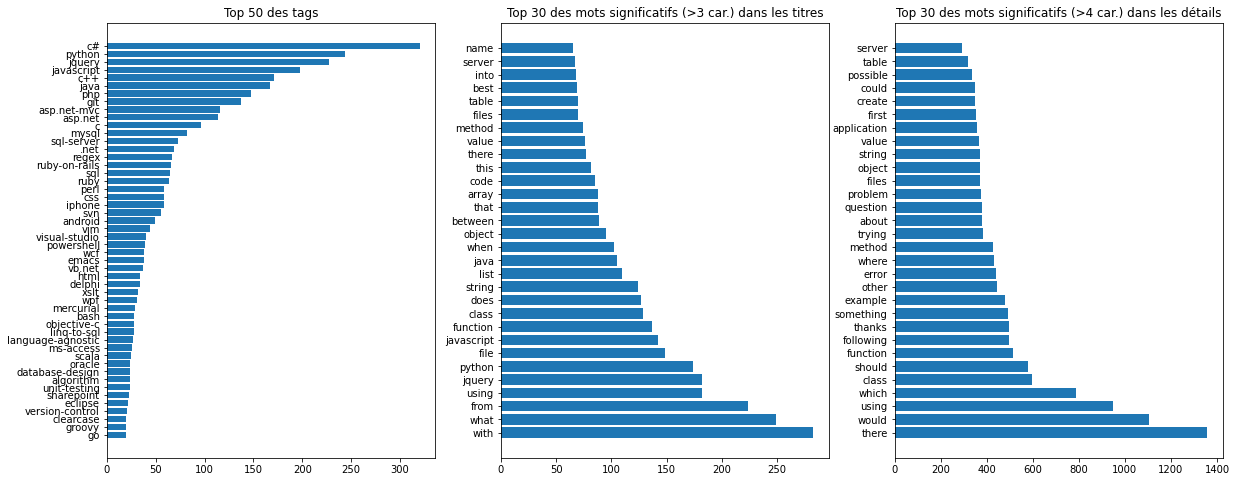

In [ ]:
fig = plt.figure(1, figsize=(20, 8))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['tags'], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['tags'], key=lambda x: x[1])])
plt.title('Top {} des tags'.format(top))

fig = plt.figure(1, figsize=(15, 8))
plt.subplot(132)
temp = {k: n for k, n in freq['questions'] if len(k)>3}
temp = sorted(temp.items(), key=lambda t: t[1], reverse=True)[:top2]
plt.barh([k for k, v in temp], [v for k, v in temp])
plt.title('Top {} des mots significatifs (>3 car.) dans les titres'.format(top2))

plt.subplot(133)
temp = {k: n for k, n in freq['bodies'] if len(k)>4}
temp = sorted(temp.items(), key=lambda t: t[1], reverse=True)[:top2]
plt.barh([k for k, v in temp], [v for k, v in temp])
plt.title('Top {} des mots significatifs (>4 car.) dans les détails'.format(top2))

Justifier le split des sw à 10%

In [ ]:
#questions
cpt = 0
for w, c in freq['questions']:
    if c >= len(freq['questions']) * .1:
        sw.update(w)
        cpt += 1
print('{} stopwords dont {} dans les questions'.format(len(sw), cpt))

cpt = 0
for w, c in freq['bodies']:
    if c >= len(freq['bodies']) * .1:
        sw.update(w)
        cpt += 1
print('{} stopwords dont {} dans les bodies'.format(len(sw), cpt))

184 stopwords dont 7 dans les questions
191 stopwords dont 34 dans les bodies


# Lemmatisation/racinisation et préparation des TF/IDF

Avec la lemmatisaton sans racinisation, des mots comme absolute/absolutely, abstract/abstraction ne sont pas groupés (cf. ci-dessous)

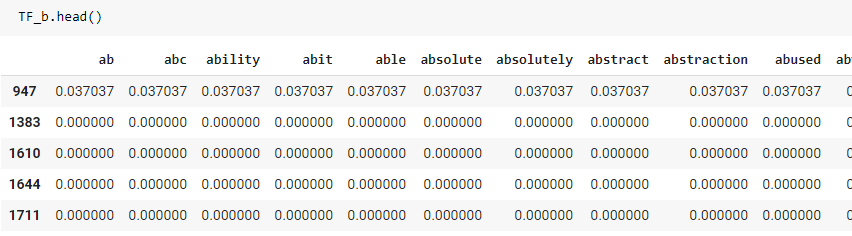

In [ ]:
def stemnlem(tokens, stopwords, stemr, lemr):
    temp = [] 
    for w in tokens:
        if w.isalpha() and w not in stopwords:
            temp.append(stemr.stem(lemr.lemmatize(w)))
    return temp, len(temp)

corpus = []
corpus_q = []
corpus_b = []
dict_TF_q = defaultdict(dict)
dict_TF_b = defaultdict(dict)

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

for i, text in source.items():
    temp = []
    title, n = stemnlem(text[0], sw, stemmer, lemmatizer)
    detail, m = stemnlem(text[1], sw, stemmer, lemmatizer)
    source[i][0] = title
    source[i][1] = detail
    temp.extend(title)
#    temp.extend(detail)
    corpus.extend(temp)
    freq = Counter(temp)
    for w in title:
        dict_TF_q[i][w] = freq[w] / (n + m)
#    for w in detail:
#        dict_TF_b[i][w] = freq[w] / (n + m)

dict_corpus = Counter(corpus)

## Term Frequencies (TF)

In [ ]:
TF_q = pd.DataFrame(dict_TF_q).fillna(0).T
TF_b = pd.DataFrame(dict_TF_b).fillna(0).T
TF_q.shape, TF_b.shape

((3476, 2571), (0, 0))

In [ ]:
TF_q.columns = TF_q.columns.sort_values()
TF_b.columns = TF_b.columns.sort_values()
TF_q.head()

,aa,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,...,worker,world,worri,wors,worth,would,wpf,wrap,writabl,write,writeabl,writefil,writeln,written,wrong,wysiwyg,x,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,xx,xxx,xyz,ye,year,yet,yield,yyyi,z,zcat,zehut,zero,zip,ziparch,zoom,ß
1023055,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.0,0.0,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.2,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.008130,0.00813,0.00813,0.00813,0.00813,0.00813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.021277,0.00000,0.00000,0.00000,0.00000,0.00000,0.021277,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.016129,0.016129,0.032258,0.016129,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
TF_b.head()

""


## IDF

In [ ]:
dict_IDF_q = defaultdict(dict)
dict_IDF_b = defaultdict(dict)

for i, text in source.items():
    for w in text[0]:
        dict_IDF_q[i][w] = np.log(N / dict_corpus[w])
#    for w in text[1]:
#        dict_IDF_b[i][w] = np.log(N / dict_corpus[w])

IDF_q = pd.DataFrame(dict_IDF_q).fillna(0).T
IDF_b = pd.DataFrame(dict_IDF_b).fillna(0).T
IDF_q.columns = IDF_q.columns.sort_values()
IDF_b.columns = IDF_b.columns.sort_values()
IDF_q.shape, IDF_b.shape

((3476, 2571), (0, 0))

In [ ]:
IDF_q.head()

,aa,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,...,worker,world,worri,wors,worth,would,wpf,wrap,writabl,write,writeabl,writefil,writeln,written,wrong,wysiwyg,x,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,xx,xxx,xyz,ye,year,yet,yield,yyyi,z,zcat,zehut,zero,zip,ziparch,zoom,ß
1023055,7.728736,7.561682,7.986565,7.641724,5.430707,9.721166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.561682,6.849486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.863951,6.557098,10.819778,10.819778,5.536575,8.622554,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.863951,0.000000,0.000000,0.000000,0.000000,0.000000,6.489045,8.517193,5.106045,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.615772,9.21034,7.824046,7.035589,7.487574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
IDF_b.head()

""


# TF-IDF

### Focus Titres

In [ ]:
dict_TFIDF_q = defaultdict(dict)
dict_TFIDF = defaultdict(dict)

for i, v in dict_TF_q.items():
    for w, c in v.items():
        dict_TFIDF_q[i][w] = c * dict_IDF_q[i][w]

dict_TFIDF = dict_TFIDF_q.copy()

tfidf = pd.DataFrame(dict_TFIDF).fillna(0).T
tfidf.columns = tfidf.columns.sort_values() 

# Ajout des tags correspondants 
tagnwords = defaultdict(list)

for i, j in tfidf.iterrows():
    tfidf.loc[i, 'tags'] = source[i][2]
#    for col in tfidf.columns[:-1].values:
#        if tfidf.loc[i, col] != 0:
#            tagnwords[', '.join(source[i][2])].append(col)

tfidf.head()

,aa,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,...,world,worri,wors,worth,would,wpf,wrap,writabl,write,writeabl,writefil,writeln,written,wrong,wysiwyg,x,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,xx,xxx,xyz,ye,year,yet,yield,yyyi,z,zcat,zehut,zero,zip,ziparch,zoom,ß,tags
1023055,0.336032,0.328769,0.347242,0.332249,0.236118,0.422659,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,vim
2177008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.512336,1.369897,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ruby
368947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047674,0.05331,0.087966,0.087966,0.045013,0.070102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.net
488240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124765,0.00000,0.000000,0.000000,0.000000,0.000000,0.138065,0.181217,0.108639,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,javascript
630434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090577,0.148554,0.252389,0.113477,0.120767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jquery


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf.iloc[:, :-1].values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00196089 0.00191792] 0.0038788053160296225


Clustering

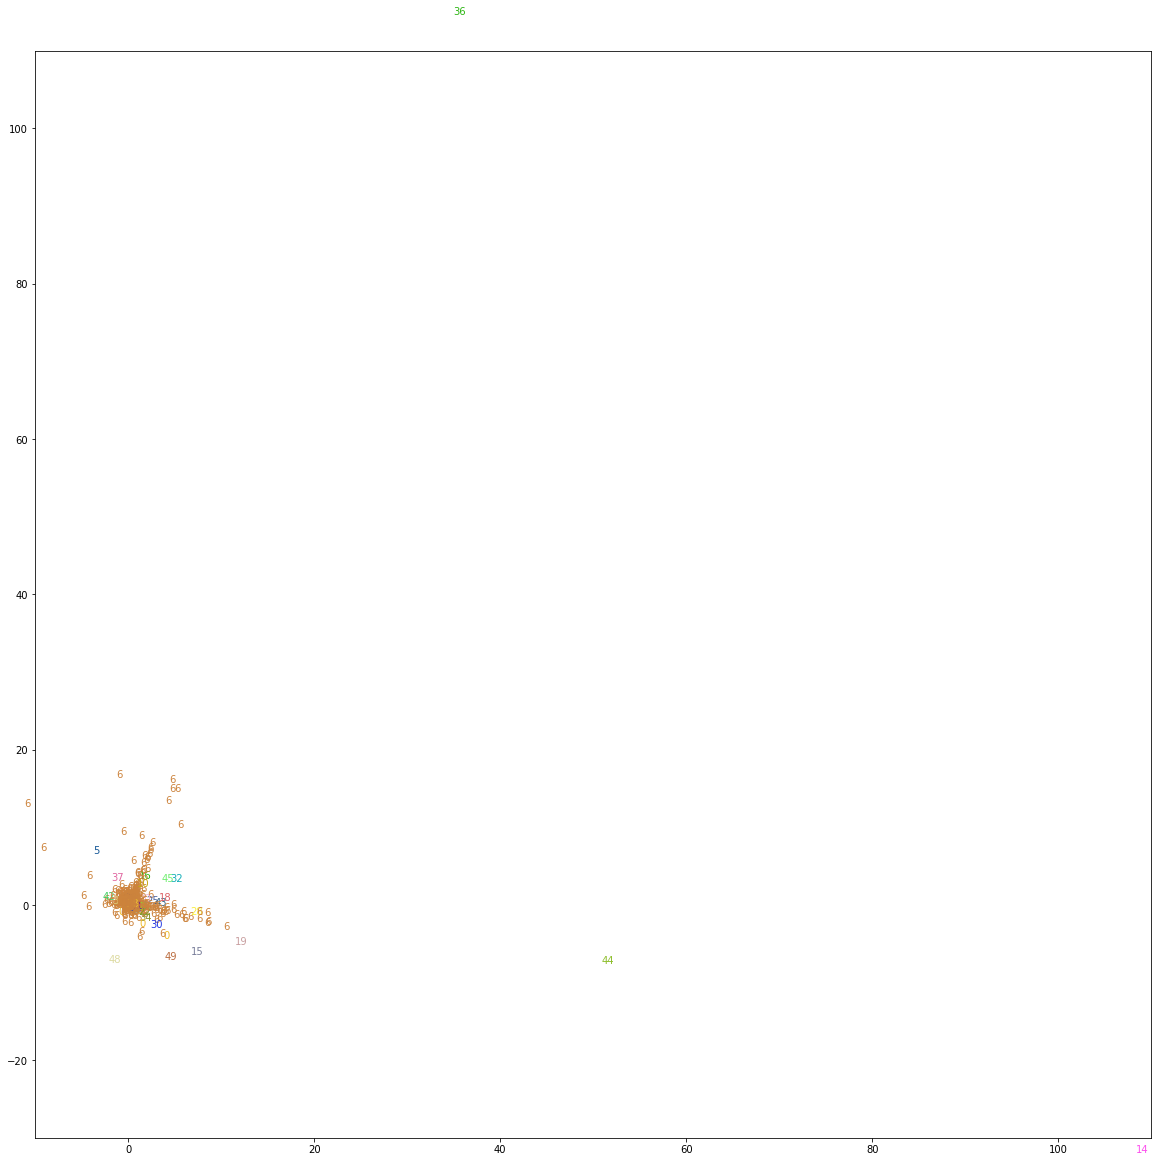

Silhouette Coefficient: -0.352


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], myclust.labels_[i],
            color=color[myclust.labels_[i]] ) #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,19,1,1,1,1,1,3409,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Classification supervisée

In [ ]:
tfidf

,aa,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,...,worri,wors,worth,would,wpf,wrap,writabl,write,writeabl,writefil,writeln,written,wrong,wysiwyg,x,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,xx,xxx,xyz,ye,year,yet,yield,yyyi,z,zcat,zehut,zero,zip,ziparch,zoom,ß,tags,cluster
1023055,0.336032,0.328769,0.347242,0.332249,0.236118,0.422659,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,vim,6
2177008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.512336,1.369897,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,ruby,6
368947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047674,0.05331,0.087966,0.087966,0.045013,0.070102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,.net,6
488240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124765,0.00000,0.000000,0.000000,0.000000,0.000000,0.138065,0.181217,0.108639,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,javascript,6
630434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090577,0.148554,0.252389,0.113477,0.120767,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,jquery,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.343279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,html,6
460115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit(tfidf.tags)
tfidf['lbl_tag'] = lbl_tag.transform(tfidf.tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf.iloc[:, :-2], tfidf.lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

ValueError: ignored

In [ ]:
gs = KNeighborsClassifier(n_neighbors=50)

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

plt.figure(figsize=(50, 50))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(gs, X_test_scaled, y_test,
                                            # display_labels=class_names,
                                            cmap=plt.cm.Blues, \
                                            normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()
print()

### Titres + détails

In [ ]:
coef = 1

dict_TFIDF_q = defaultdict(dict)
dict_TFIDF_b = defaultdict(dict)
dict_TFIDF = defaultdict(dict)

for i, v in dict_TF_q.items():
    for w, c in v.items():
        dict_TFIDF_q[i][w] = coef * c * dict_IDF_q[i][w]
for i, v in dict_TF_b.items():
    for w, c in v.items():
        dict_TFIDF_b[i][w] = (1 - coef) * c * dict_IDF_b[i][w]

for i in source.keys():
    for w in dict_corpus.keys():
        dict_TFIDF[i][w] = dict_TFIDF_q[i].get(w, 0) + dict_TFIDF_b[i].get(w, 0)

tfidf = pd.DataFrame(dict_TFIDF).T
tfidf.columns = tfidf.columns.sort_values() 
tfidf.head()

A des fins d'analyse, j'ajoute les tags correspondants à TFIDF

In [ ]:
tagnwords = defaultdict(list)

for i, j in tfidf.iterrows():
    tfidf.loc[i, 'tags'] = source[i][2]
    for col in tfidf.columns[:-1].values:
        if tfidf.loc[i, col] != 0:
            tagnwords[', '.join(source[i][2])].append(col)

#tagnwords['c#']

# Clustering

In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

X = tfidf.iloc[:, :-1].values

# On commence par réduire la dimension des données avec tSNE. On scale d’abord les données :
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Puis on applique tSNE aux données scalées :
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], myclust.labels_[i],
            color=color[myclust.labels_[i]] ) #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

In [ ]:
tfidf.head()

In [ ]:
tfidf[(tfidf.cluster == 0)]

# LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 50

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tfidf.iloc[:, :-2])

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tfidf.columns[:-1], no_top_words)

## Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit(tfidf.tags)
tfidf['lbl_tag'] = lbl_tag.transform(tfidf.tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf.iloc[:, :-3], tfidf.lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

In [ ]:
gs = KNeighborsClassifier(n_neighbors=50)

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

plt.figure(figsize=(15, 15))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(gs, X_test_scaled, y_test,
                                            # display_labels=class_names,
                                            cmap=plt.cm.Blues, \
                                            normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()
print()